In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

In [2]:
class_map_s2i = {
    'person': 0, 'car': 1, 'building': 2, 'window': 3, 'tree': 4,
    'sign': 5, 'door': 6, 'bookshelf': 7, 'chair': 8, 'table': 9,
    'keyboard': 10, 'head': 11, 'Unknown': 12
}

class_map_i2s = {v: k for k, v in class_map_s2i.items()}

In [3]:
def load_mobilenet_v3_small(model_path="models/pretrained_MobileNet_V3_small.pth"):
    # Create an EffNetB2 feature extractor
    def create_mobilenet_v3_small():
        # Set the manual seeds
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)

        # Get the length of class_names (one output unit for each class)
        class_names = class_map_s2i.keys()
        output_shape = len(class_names)

        # Get the base model with pretrained weights and send to target device
        weights = torchvision.models.MobileNet_V3_Small_Weights.DEFAULT
        model = torchvision.models.mobilenet_v3_small(weights=weights).to('cpu')

        # Change the classifier head
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=576, out_features=output_shape)
        ).to('cpu')

        # Give the model a name
        model_name = "mobilenet_v3_small"
        print(f"[INFO] Created new {model_name} model.")
        return model

    saved_model = create_mobilenet_v3_small().to('cpu')
    saved_model.load_state_dict(torch.load(model_path, map_location='cpu'))
    saved_model.eval()
    return saved_model

In [4]:
def predict_image(image_path, model=load_mobilenet_v3_small()):
    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model(image)

    predicted_class = torch.argmax(output, dim=1).item()
    probability = torch.softmax(output, dim=1)[0][predicted_class].item()

    # Display the image
    plt.imshow(image.squeeze(0).permute(1, 2, 0))  # Transpose to (H, W, C)
    plt.title(f'Predicted Class: {class_map_i2s[predicted_class]}, Probability: {probability:.4f}')
    plt.axis('off')
    plt.show()

    return class_map_i2s[predicted_class], probability

[INFO] Created new mobilenet_v3_small model.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO] Created new mobilenet_v3_small model.


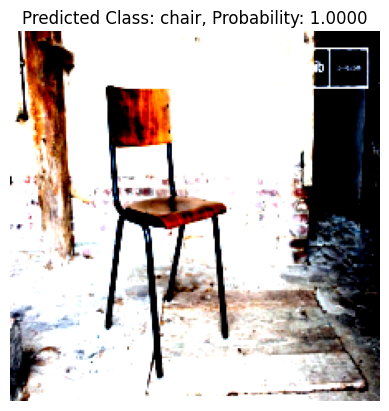

Predicted Class: chair, Probability: 1.0000


In [5]:
# Test the model on a single image:
predicted_class, probability = predict_image('chair.jpg', load_mobilenet_v3_small())
print(f'Predicted Class: {predicted_class}, Probability: {probability:.4f}')